In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt
import scipy.sparse as sps
from random import randint
import operator
df = pd.read_csv('online_retail_transaction.csv',header=None,index_col=None)
df.shape # dimensione originale

(4372, 4223)

In [150]:
def compute_band_matrix(original_dataset=None, dim_finale=1000, nome__file_item=None, num_sensibile=1):
    """
        Compute band_matrix , permutazione casuale di righe e colonne
        estrapola a caso item_sensibili
    """
    if original_dataset is not None and len(original_dataset) >= dim_finale and len(original_dataset.columns) >= dim_finale:
        # leggo nomi items
        file = open(nome__file_item, "r")
        items = file.read().splitlines()
        # permuto righe e colonne del df inizale e prendo le prime :dim_finale
        np.random.seed(seed=13)
        random_column = np.random.permutation(df.shape[1])[:dim_finale]
        random_row = np.random.permutation(df.shape[0])[:dim_finale]
        # recupero gli item selezionati nel relativo ordine == colonne
        items_reordered = [items[i] for i in random_column]
        # df selezionato e square
        
        # eliminare le righe nulle a priori
        df_square = df.iloc[random_row][random_column];
        # eliminare solo se items sensibili nulli
        
        # selezioni gli utlimi num_sensibili come item sensibili
        # check se esiste almeno un item sensibile

        # remove dati sensibili add zero --> compute RCM --> remove zero e add dati sensibili
        # df_sensibili = df_square[df_square.columns[-num_sensibile:]]
        # df_common_items = df_square[df_square.columns[0:-num_sensibile]]
        # zero_data_to_add = np.zeros(shape=(len(df_common_items),num_sensibile))
        # columns_to_add = ["temp_"+str(x) for x in range(0,num_sensibile)]
        # df_zeri = pd.DataFrame(zero_data_to_add, columns=columns_to_add,index=df_common_items.index,dtype='uint8')
        # df_square = pd.concat([df_common_items,df_zeri],axis=1)
        # print(df_zeri.shape) dim_finalexnum_sensibili
        # print(df_square.shape)
        # subplot with y condiviso

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        
        # check che le colonne sensibili non siano nulle
        lista_sensibili = df_square.columns[-num_sensibile:]
        # plot matrice sparsa iniziale
        # plt
        ax1.spy(df_square, marker='.', markersize='1')
        #ax1.show()

        # applicazione algoritmo RCM
        sparse = csr_matrix(df_square)
        order = reverse_cuthill_mckee(sparse)

        # solo se add gli 0
        # riordino i dati sensibili
        # df_sensibili = df_sensibili.iloc[order]

        # ora devo prendere gli item selzionati prima e riordinarli ancora
        # secondo quello scritto in order quindi
        items_final = [items_reordered[i] for i in order]
        column_reordered = [df_square.columns[i] for i in order]
        # df bandizzato
        df_square_band = df_square.iloc[order][column_reordered]
        # plotto
        ax2.spy(df_square_band, marker='.', markersize='1')
        #ax2.show()
        plt.show()
        # banda dataframe inizale
        [i, j] = np.where(df_square == 1)
        bw = max(i-j) + 1
        print("Bandwidth first RCM", bw)

        # banda dataframe dopo RCM
        [i, j] = np.where(df_square_band == 1)
        bw = max(i-j) + 1
        print("Bandwidth after RCM", bw)
        return df_square_band, items_final, lista_sensibili


def check_conflict(dataframe, row_i, row_j, items_sensibili):
    # se hanno un items sensibile in comune allora sono in conflitto
    dati_sensibili_row_i = items_sensibili[np.where(dataframe.iloc[row_i][items_sensibili] == 1)]
    dati_sensibili_row_j = items_sensibili[np.where(dataframe.iloc[row_j][items_sensibili] == 1)]
    # create set
    set_j = set(dati_sensibili_row_j)
    set_i = set(dati_sensibili_row_i)
    # check intersection
    return len(set_i.intersection(set_j)) > 0


def compute_hist(dataframe, items_sensibili):
    hist = dict(dataframe[items_sensibili].sum())
    return hist


def compute_candidate_list(dataframe, indice_transizione_sensibile, alpha_p, item_sensibili, all_transazioni_sensibili):
    lc = list()  # lista candidate
    k = 1;  #<------------------ aaaaaargh!! a ";">
    # controllo gli alpha*p transazioni precedenti non sono in conflitto
    cond = max(indice_transizione_sensibile - alpha_p - k, -1)
    i = indice_transizione_sensibile - 1;
    while (i > cond):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, item_sensibili):
                k = k + 1
            else:
                lc.append(i)
        cond = max(indice_transizione_sensibile - alpha_p - k, -1)
        i -= 1
        
    # alpha*p transizioni successive che non sono in conflitto
    k = 1
    cond = min(indice_transizione_sensibile + alpha_p + k, len(dataframe))
    i = indice_transizione_sensibile + 1
    while(i < cond):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, items_sensibili):
                k = k + 1
            else:
                lc.append(i)
        cond = min(indice_transizione_sensibile + alpha_p + k, len(dataframe))
        i += 1
    
    error = False
    if len(lc) < alpha_p:
        error = True
        
    return lc,error


def selectBestTransactions(df, candidate_list, transaction_target, p):#manca l'argomento items_sensibili, ma funziona..

    all_items = list(df)
    QID_items = [x for x in all_items if x not in items_sensibili]

    #lista riportante gli item in comune con transactionTarget
    distance = list()    
    for row in candidate_list:
        list1 = df.iloc[transaction_target][QID_items]
        list2 = df.iloc[row][QID_items]
        #da queste due liste, devo escludere le transazioni sensibili.

        #num. elementi in comune di due liste
        distance.append(sum([x and y for x, y in zip(list1, list2)]))

    #ottengo i p-1 indici della lista candidata con distanza maggiore
    major_indexs = list()
    for i in range(0, p-1):
        max_index,max_value = max(enumerate(distance), key=operator.itemgetter(1))
        major_indexs.append(max_index)
        distance[max_index] = -1

    #seleziono gli indici delle righe del dataframe con maggior QIitems in comune
    best_rows = list()
    for i in major_indexs:
        best_rows.append(candidate_list[i])

    return best_rows


def CAHD(dataframe_bandizzato_temp, items_sensibili, nome_item, grado_privacy, alfa=3):
    """
        funzione per il calcolo di CAHD su un dataframe_bandizzato dopo RCM
        con gli items sensibili (vedi paper per teoria)
    """
    # temp per non modificare quello originale
    dataframe_bandizzato = dataframe_bandizzato_temp.copy()
    #print(len(dataframe_bandizzato))
    
    # calcolo istogramma per i dati sensibili (visto come dizionario)
    hist = compute_hist(dataframe_bandizzato, items_sensibili)
    
    # lunghezza del dataframe
    remaining = len(dataframe_bandizzato)
    
    # gruppi anonimizzati
    # G = pd.DataFrame(columns=dataframe_bandizzato.columns)

    # inidice delle righe delle transazioni sensibili non ripetute
    transazioni_sensibili = set(list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0]))
    # indice delle transizioni sensibili con mapping 1-1 con item_sensibile_per_transizione
    # transazioni_sensibili_completa[i] --> indice della transizione
    # item_sensibile_per_transazioni[i] --> item sensibile per la transizione sopra
    transazioni_sensibili_completa = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0])
    hash_transiction = dict()
    # item sensibili della transazione iesime
    item_sensibile_per_transazioni = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[1])

 
    # riempo il dizionario (hash_map) indicizzata con il numero della riga
    for t in transazioni_sensibili:
        index_t = np.where(np.array(transazioni_sensibili_completa) == t)[0]
        hash_transiction[t] = [item_sensibile_per_transazioni[i] for i in index_t]

    # indicizzata le righe delle transizioni contententi l'indice della lista item_sensibili dove è contenuto l'uno
    # print(hash_transiction)
    # lista candidata
    lc = dict()
    
    

    
    
    #FORMO IL DATAFRAME ANONIMIZZATO [item sensibili sono riportati a destra]
    #Nota: codice aggiunto. Molti di questi argomenti possono essere passati esternamente e passati a loro volta 
    #a funzioni interne
    all_items = list(df_square.columns)
    QID_items = [x for x in all_items if x not in items_sensibili]
    columns_list = QID_items
    for x in items_sensibili:
        columns_list.append(x)
    dataframe_anonimizzato = pd.DataFrame(columns=columns_list,index=df_square.index)
    

    dict_group = list()
    
    
    #FIX: CAMBIO LA MEMORIZZAZIONE DA NUM.RIGA A LABEL RIGA
    id_sensitive_transaction = dataframe_bandizzato.iloc[list(transazioni_sensibili)].index
    print(id_sensitive_transaction)
    
    
    #Ciclo finchè ho gruppi da anonimizzare
    done = False
    while(!done)
    
    for q in id_sensitive_transaction:
        
        #FIX: PASSO DA LABEL RIGA A NUMERO RIGA
        #devo gestire il caso in cui una riga sensibile venga messa in un gruppo e cancellata!!
        tentativo = True
        while(tentativo):
            try:
                t = dataframe_bandizzato.index.get_loc(q)
                print("TRANSAZIONE SENSIBILE:",t)
                tentativo = False
            except ValueError:
                continue
        
        #lista candidata LC 
        lc,errore = compute_candidate_list(dataframe_bandizzato, t, grado_privacy * alfa, items_sensibili, transazioni_sensibili)
        if not errore:
            group = selectBestTransactions(dataframe_bandizzato, lc, t, grado_privacy)
            #aggiungo la transazione bersaglio
            group.append(t)
            # somma degli items sensibili del gruppo
            selected_sensitive_items = dataframe_bandizzato.iloc[group][items_sensibili].sum()
            # temp hist
            temp_hist = hist
            # aggiorno le occorrenze di ogni item sensbile
            print("formo il gruppo",group)
            for index in selected_sensitive_items.index:
                temp_hist[index] -= selected_sensitive_items.loc[index] 
            #print(selected_sensitive_items)
            # controllo se si possono ancora creare gruppi
            found = False
            for index in temp_hist.keys():
                # se non si può più soddisfare il grado di privacy
                if temp_hist[index] * grado_privacy > remaining:
                    found = True
                    break

            if not found:
                print("il gruppo è ok")
                
                
                
                
                #DEVO RIMUOVERE EVENTUALI TRANSAZIONI SENSIBILI COMPRESE NEL GRUPPO DA id_sensitive_transaction
                id_sensitive_transaction = [x for x in id_sensitive_transaction if x not in l2]
                
                
                
                
                
                
                
                # gruppo is ok
                # compute anonimizzation
                # indice iesimo -> indice delle transazioni del gruppo iesimo
                dict_group.append(dataframe_bandizzato.index[group])
                
                # metto i QID nel datframe anonimizzato
                dataframe_anonimizzato.loc[list(dataframe_bandizzato.index[group])] = dataframe_bandizzato.loc[list(dataframe_bandizzato.index[group])]
                for index in list(dataframe_bandizzato.index[group]):
                    # metto la somma dei SD del gruppo per ogni row del gruppo
                    dataframe_anonimizzato.loc[index][selected_sensitive_items.index] = selected_sensitive_items
                
                # le droppo dal df iniziale
                dataframe_bandizzato = dataframe_bandizzato.drop(list(dataframe_bandizzato.index[group]))
                
                #BISOGNA RIMETTERE A POSTO LE RIGHE (  *   ___<____    *  )
                
                
                
                # compute row rimanenti
                remaining = len(dataframe_bandizzato.index)
                print("rimangono",remaining,"transazioni")
                
            else:
                # gruppo non va bene
                print("gruppo non va bene")
    return dataframe_anonimizzato


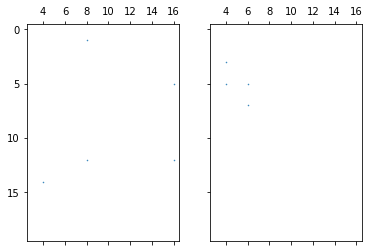

Bandwidth first RCM 11
Bandwidth after RCM 2
Int64Index([226, 1278, 668], dtype='int64')
TRANSAZIONE SENSIBILE: 1
formo il gruppo [0, 2, 3, 1]
il gruppo è ok
rimangono 16 transazioni
TRANSAZIONE SENSIBILE: 1
formo il gruppo [0, 2, 3, 1]
il gruppo è ok
rimangono 12 transazioni


KeyError: 668

In [151]:
df_square,items,items_sensibili = compute_band_matrix(original_dataset = df, dim_finale = 20, nome__file_item="lista_items.txt",num_sensibile=4)
lista = CAHD(df_square,items_sensibili,[],4)
lista

In [148]:
df_square

,1182,2293,1968,3822,114,1341,3208,491,1216,27,4184,522,1356,3577,1736,3830,2768,4125,1363,1688
1460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
226,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1179,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1278,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
668,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:


id_sensitive_transaction = lista2.index.get_loc(1082)
print(id_sensitive_transaction)

0


In [137]:
lista2

,2293,1968,3822,114,1341,491,27,4184,522,1356,3577,3830,2768,4125,1363,1688,3208,1182,1736,1216
1082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1179,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
668,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
#df_square.loc[85]#torna la riga con ID 85

In [151]:
list1 = df_square.iloc[640]
list2 = df_square.iloc[630]

In [142]:
#distanza tra due liste
sum([x and y for x, y in zip(list1, list2)])

0

In [ ]:
a = [0, 0,0,1,2]

In [ ]:
b = [2,1,1,3,3]

In [ ]:
np.where(np.array(a)==0)

In [158]:
all_items = list(df_square)
QID_items = [x for x in all_items if x not in items_sensibili]

In [160]:
len(QID_items)

696

In [164]:
len(list(df_square.iloc[640][QID_items]))

696